<table align="left">
  <td>
    <a href="https://colab.research.google.com/drive/1RvxOhf2dwOFaP9ND6BetkJDhZIH6b8T8" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

Este *notebook* trata sobre búsquedas y tiene una celda interactiva, medinte la cual vamos a *dibujar* los obstáculos de la búsqueda sobre un espacio cuadriculado.

# **Crecimiento exponencial del espacio de estados**

Antes de empezar las búsquedas en un cuadrilátero, como haremos después, vamos a representar el crecimiento del espacio de estados a medida que crece alguna de sus características.

Por ejemplo, en el problema de la N reinas, ¿cómo crece el espacio de estados a medida que aumenta N?

En este caso es una explosión de naturaleza combinatoria.

Tamaño del espacio de estados para N-reinas $=\sum_{k=0}^{N}{\binom{N^2}{k}}$

**Observa que**: ¡El eje de las $y$ es logarítmico!

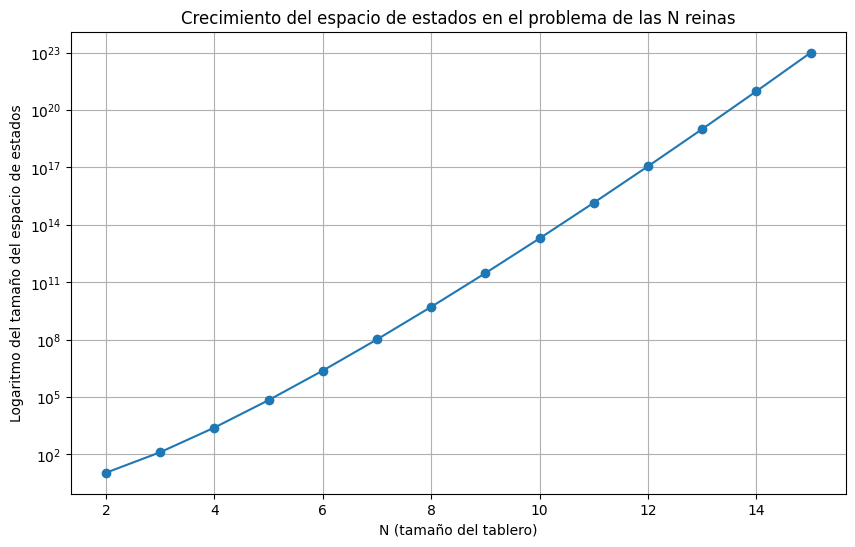

In [1]:
import matplotlib.pyplot as plt
from scipy.special import comb

def state_space_size(N):
    return sum(comb(N * N, k) for k in range(N + 1))

N_values = list(range(2, 16))  # Aquí puedes extender el rango si lo deseas
sizes = [state_space_size(N) for N in N_values]

plt.figure(figsize=(10, 6))
plt.plot(N_values, sizes, marker='o')
plt.yscale("log")  # Escala logarítmica en el eje de las ordenadas
plt.xlabel('N (tamaño del tablero)')
plt.ylabel('Logaritmo del tamaño del espacio de estados')
plt.title('Crecimiento del espacio de estados en el problema de las N reinas')
plt.grid(True)
plt.show()


# **Estrategias de búsqueda sin/con información**

Vamos a ver y codificar algunos algoritmos de búsqueda. En concreto Dijkstra y A*.

## **Empecemos por celdas con código dependiente del sistema**

In [2]:
# lo que sigue es exclusivo de Google Colab.

from google.colab import output
output.enable_custom_widget_manager()


In [3]:
# instalamos el paquete que nos permite trabajar con canvas en los notebooks.
# sólo es necesario en Google Colab y sólo una vez, al inicio de la sesión

!pip install -q ipycanvas==0.11

!pip install -q ipyevents


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.7 MB/s eta 0:00:00


## **Empieza el código**



In [4]:
# importamos varias cosas que nos harán falta

from ipycanvas  import Canvas;
from ipywidgets import Image;
from time       import sleep;

import ipycanvas;
import ipyevents;
import operator;
import random;
import time;
import math;
import json;
import copy;

import os.path


Vamos a crear varias funciones que nos facilitarán la vida:

- **rgb2html**: esta función recibe un color en formato RGB y devuelve un *string* con el color en formato #RRGGBB.
- **printCellInfo**: a partir de la info de la celda, imprime el texto que la caracteriza en el canvas, en la celda (i,j).
- **printBoard**: *simplemente* pinta el tablero en el canvas teniendo en cuenta todos los estados de las celdas.

In [5]:
ORIGIN=1;
TARGET=2;
WALL  =3;

# esta función convierte una combinación RGB a un string usable en CSS/HTML
def rgb2html(r,g,b):
    return "#{:02x}{:02x}{:02x}".format((r&0xFF),(g&0xFF),(b&0xFF));

# esta función "pinta" el tablero en un 'canvas' que le pasamos como parámetro.
def printBoard(canvas, cols, rows, board=None, estados=None, target=None, origin=None, text=True):
    assert type(cols)==int;
    assert type(rows)==int;
    with ipycanvas.hold_canvas(canvas):
         canvas.clear();
         canvas.line_width=1;
         canvas.font = '8px serif';
         canvas.fill_style="black";
         canvas.stroke_rect(0,0,canvas.width-1,canvas.height-1);

         ix=canvas.width/float(cols);
         for i in range(cols):
             canvas.stroke_line(i*ix,0,i*ix,canvas.height-1);

         iy=canvas.height/float(rows);
         for j in range(rows):
             canvas.stroke_line(0,j*iy,canvas.width-1,j*iy);

         if board!=None and type(board)==list:
            abiertos=None if estados==None else estados[0];
            cerrados=None if estados==None else estados[1];

            path=[];
            if cerrados!=None:
               t=target;
               while (t!=None) and (t!=origin):
                     path.append(t);
                     if t in cerrados: t=cerrados[t]["parent"];
                     else:             break;

            for i in range(cols):
                for j in range(rows):

                    assert type(board[i][j])==int;

                    assert (abiertos==None and cerrados==None) or ((not (i,j) in abiertos) and (not (i,j) in cerrados)) or ((i,j) in abiertos) != ((i,j) in cerrados);

                    if (abiertos!=None) and ((i,j) in abiertos):
                       canvas.fill_style=rgb2html(0,255,0) if (i,j) in path else rgb2html(200,255,200);
                       canvas.fill_rect(i*ix+1,j*iy+1,ix-2,iy-2);
                    if (cerrados!=None) and ((i,j) in cerrados):
                       canvas.fill_style=rgb2html(0,255,0) if (i,j) in path else rgb2html(200,200,200);
                       canvas.fill_rect(i*ix+1,j*iy+1,ix-2,iy-2);
                    if board[i][j]==ORIGIN:
                       canvas.fill_style=rgb2html(0,0,255);
                       canvas.fill_rect(i*ix+1,j*iy+1,ix-2,iy-2);
                    if board[i][j]==TARGET:
                       canvas.fill_style=rgb2html(255,0,0);
                       canvas.fill_rect(i*ix+1,j*iy+1,ix-2,iy-2);
                    if board[i][j]==WALL:
                       canvas.fill_style=rgb2html(0,0,0);
                       canvas.fill_rect(i*ix,j*iy,ix,iy);


In [7]:
WIDTH =900; # alto del tablero, en pixels
HEIGHT=300; # ancho del tablero, en pixels
ROWS=20;    # cuantas fileas tiene el tablero
COLS=60;    # cuantas columnas tiene el tablero

# creamos el tablero como una lista de listas (array bidimensionales).
board=[[0 for j in range(ROWS)] for i in range(COLS)];

# ponemos en las celdas correspondientes las cuadrículas inicio y fin.
board[ 2][ 2]=1;
board[-3][-3]=2;


### **ATENCIÓN**

**Esta celda es muy especial. Es interactiva.**

Muestra el tablero y permite añadir los muros (obstáculos).

Simplemente ejecuta la celda y en el tablero que muestra usa el botón del ratón para poner/borrar los muros.

El tablero no se guarda entre sesión y sesión, pero en cada sesión puedes venir a esta celda, ejecutarla y modificar el tablero y sus obstáculos. **Si ejecutas la celda anterir, resetea el tablero.**

In [8]:
canvas=Canvas(width=WIDTH, height=HEIGHT);
display(canvas);
printBoard(canvas, COLS, ROWS, board);

def handle_mouse_down(x,y):
    global board;
    ix=int(canvas.width/COLS);
    iy=int(canvas.height/ROWS);
    col=int(x//ix);
    row=int(y//iy);
    if    board[col][row]==0:    board[col][row]=WALL;
    elif  board[col][row]==WALL: board[col][row]=0;
    printBoard(canvas, COLS, ROWS, board);

canvas.on_mouse_down(handle_mouse_down);


Canvas(height=300, width=900)

### **Algoritmo genérico "best-first search"**

La **búsqueda del mejor primero** (*best-first search*) es una clase de algoritmos de búsqueda que exploran un grafo expandiendo el nodo más prometedor elegido según una regla especificada.

Algunos autores han utilizado el término "*búsqueda del mejor primero*" para referirse específicamente a una búsqueda con una heurística que intenta predecir lo cerca que está el final de un camino de una solución, de modo que los caminos que se consideran más cercanos a una solución se extienden primero.

La selección eficiente del mejor candidato actual para la extensión se implementa típicamente usando una cola de prioridad. La prioridad en esta cola se establece mediante la distancia $f(n)$ para un nodo $n$.

En general $f(n)$ se define de la siguiente manera:

$$ f(n)=g(n)+h(n) $$

Siendo $g(n)$ la distancia de la mejor trayectoria desde el origen al nodo $n$ (Dijkstra) y $h(n)$ la distancia de la mejor trayectoria del nodo $n$ al objetivo (A*) buscado. Como no tenemos tanta información como para determinar con exactitud $h(n)$ tenemos que conformarnos con una estimación: $h'(n)$, así pues

$$ f(n)=g(n)+h'(n) $$

es nuestra mejor estimación.

Vamos a codificar un algoritmo de búsqueda *best-first* y lo parametrizaremos para que con un pequeño cambio se comporte como el algoritmo de Dijkstra o como el algoritmo A*.




In [9]:
# Empezemos por unas funciones de apoyo, para simplificar el algoritmo.

"""
 Cálculo de la distancia entre dos puntos.
 Este cálculo es MUY importante.
 Puede hacerse de múltiples maneras y dependen del conocimiento del problema.
 Aquí usaremos la distancia euclídea entre pixels (no entre celdas).
 Uso: dadas las celdas 'a' y 'b', que distancia euclídea hay entre ellas.
 'a' y 'b' deben ser tuplas de la forma (x,y)
"""
def distance(a,b):
    assert type(a)==tuple and len(a)==2;
    assert type(b)==tuple and len(b)==2;
    ix=WIDTH/COLS;
    iy=HEIGHT/ROWS;
    x1=(a[0]*ix)+(ix/2);
    y1=(a[1]*iy)+(iy/2);
    x2=(b[0]*ix)+(ix/2);
    y2=(b[1]*iy)+(iy/2);
    d=math.sqrt((float(x2-x1)**2)+(float(y2-y1)**2));
    return d;

"""
 Esta función será usada en un filtro.
 Devuelve True si la celda 'p' está dentro del tablero y no es un muro.
 En caso contrario devuelve False.
"""
def checkLimits(p):
    assert type(p)==tuple and len(p)==2;
    return (p[0] in range(COLS)) and (p[1] in range(ROWS) and board[p[0]][p[1]]!=WALL);

"""
 Calcula f(n)=g(n)+h(n) usando los parámetros α y β.
 Si α=1 y β=0 => Dijkstra
 Si α=1 y β=1 => A*
"""
def f(n, α=1, β=1):
    assert type(n)==dict;
    assert "g" in n;
    assert "h" in n;
    return (n["g"]*α + n["h"]*β);


In [10]:
# algoritmo Best-first search

def bestFirstSearch(canvas, board, **kwargs): #tm=0.25, text=False

    if "alpha" in kwargs: alpha=kwargs["alpha"];
    else:                 alpha=1;

    if "beta"  in kwargs: beta=kwargs["beta"];
    else:                 beta=1;

    if "tm"    in kwargs: tm=kwargs["tm"];
    else:                 tm=1;

    if "text"  in kwargs: text=bool(kwargs["text"]);
    else:                 text=False;

    assert type(alpha) in [int,float];
    assert type(beta ) in [int,float];
    assert type(tm   ) in [int,float];
    assert type(text )==bool;

    origin=None;
    target=None;

    for i in range(COLS):
        for j in range(ROWS):
            if board[i][j]==ORIGIN:
               assert origin==None, "sólo puede haber un origen";
               origin=(i,j);
            if board[i][j]==TARGET:
               assert target==None, "sólo puede haber un objetivo";
               target=(i,j);

    assert origin!=None and target!=None, "El origen y el destino deben estar definidos";

    abiertos={ origin:{"g":0, "h":distance(origin,target), "parent":None} };
    cerrados={};

    while abiertos:

          printBoard(canvas, COLS, ROWS, board, (abiertos,cerrados), target, origin, text);
          time.sleep(tm);

          # busca en 'abiertos' el de menor 'f' (='g'+'h')
          actual=None;
          for n in abiertos:
              if actual==None:
                 actual=n;
              else:
                 if f(abiertos[n],alpha,beta) < f(abiertos[actual],alpha,beta):
                    actual=n;

          assert actual!=None;

          # saca 'q' de la lista de abiertos, pero guarda su valor.
          actual_i=abiertos[actual];
          del abiertos[actual];
          # pone a 'q' en la lista de cerrados.
          cerrados[actual]=actual_i;

          if actual==target:
             break;

          # genera los sucesores de 'q'.
          # hay que comprobar límites del tablero (y los obstáculos).
          ss=[
              tuple(map(operator.add, actual, (-1,-1))),
              tuple(map(operator.add, actual, ( 0,-1))),
              tuple(map(operator.add, actual, (+1,-1))),
              tuple(map(operator.add, actual, (-1, 0))),
              tuple(map(operator.add, actual, (+1, 0))),
              tuple(map(operator.add, actual, (-1,+1))),
              tuple(map(operator.add, actual, ( 0,+1))),
              tuple(map(operator.add, actual, (+1,+1)))
            ];
          ss=filter(checkLimits,ss);

          # ss contiene hora los hijos válidos de actual
          for s in ss:

              if s==origin: continue;

              s_i={"g":(actual_i["g"]+distance(actual,s)), "h":distance(s,target), "parent":actual};

              # comprobación: no puede estar en abiertos y cerrados al mismo tiempo
              assert not ((s in abiertos) and (s in cerrados));

              # si 's' está en 'abiertos' (s') con un s'.f < s.f => descarta s
              if s in abiertos:
                 if f(abiertos[s],alpha,beta) > f(s_i,alpha,beta):
                    abiertos[s]=s_i;

              # is s está en 'cerrados' (s') con un s'.f < s.f => descarta s, en caso contrario añade s' a 'abiertos'
              elif s in cerrados:
                 if f(cerrados[s],alpha,beta) > f(s_i,alpha,beta):
                    del cerrados[s];
                    abiertos[s]=s_i;

              else:
                 abiertos[s]=s_i;

    printBoard(canvas, COLS, ROWS, board, (abiertos,cerrados), target, origin, text);

    return ((target in cerrados), f(cerrados[target])) if (target in cerrados) else (False, None);


## **Ejemplos de uso**
Vamos a usar el anterior algoritmo para poner en evidencia los resultados según Dijkstra (alpha=1, beta=0) o según A* (alpha=1, beta=1)

In [11]:
# algoritmo de Dijkstra

canvas=Canvas(width=WIDTH, height=HEIGHT);
display(canvas);

ok, d = bestFirstSearch(canvas, board, alpha=1, beta=0, tm=0.0);

if ok: print("Objetivo alcanzado: {}".format(d));
else:  print("No he alcanzado el objetivo");

Canvas(height=300, width=900)

Objetivo alcanzado: 1013.3452377915605


In [12]:
# algoritmo A*

canvas=Canvas(width=WIDTH, height=HEIGHT);
display(canvas);

ok, d = bestFirstSearch(canvas, board, alpha=1, beta=1, tm=0.0);

if ok: print("Objetivo alcanzado: {}".format(d));


Canvas(height=300, width=900)

Objetivo alcanzado: 1013.3452377915605
